# Statistical Methods for Machine Learning NN Project - Paolo Cortis

Running different experiments with different Neural Network models for a binary classification task (classify images of cat/dog).

## Libraries

In [1]:
import os
import cv2
import itertools

import numpy as np  # Python Mathematical Library
import tensorflow as tf # Machine learning Library
from tensorflow.keras import activations, layers, optimizers, losses
from tensorflow.keras.utils import to_categorical
from tensorflow import keras

from matplotlib import pyplot as plt # Visualization Library
from plot_keras_history import plot_history
%matplotlib inline

## Data loading and pre-processing

#### Function: Load, resize and convert to gray scale images

    Parameters
    ------------------------
    folder: str
    The name of the folder from which import images.
        
    Returns
    ------------------------
    images: np.array
    The images resized and converted to gray scale.

In [2]:
def loadArrangeImages(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            resizedImg = cv2.resize(img,(100, 100), interpolation = cv2.INTER_CUBIC)
            RGBImg = cv2.cvtColor(resizedImg, cv2.COLOR_BGR2RGB)
            grayImg = cv2.cvtColor(resizedImg, cv2.COLOR_RGB2GRAY)
            images.append(grayImg)
    return np.array(images)

### Build, visualize and normalize the dataset

In [3]:
folderCats = 'D:\CatDog_Dataset\CatsDogs\Cats'
folderDogs = 'D:\CatDog_Dataset\CatsDogs\Dogs'

cats_x = loadArrangeImages(folderCats)
dogs_x = loadArrangeImages(folderDogs)

Cat images shape: [n.images, width, height] (12476, 100, 100), type: <class 'numpy.ndarray'>
Dog images shape: [n.images, width, height] (12470, 100, 100), type: <class 'numpy.ndarray'>


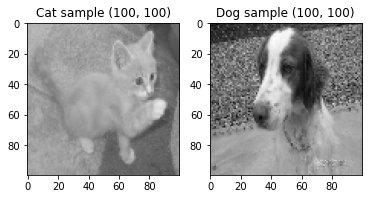

In [4]:
# Images shape and visualization
print("Cat images shape: [n.images, width, height] " + str(cats_x.shape) + ", type: " + str(type(cats_x)))
print("Dog images shape: [n.images, width, height] " + str(dogs_x.shape) + ", type: " + str(type(dogs_x)))

catSample = cats_x[1456]
dogSample = dogs_x[1456]

plt.subplot(1,2,1),plt.imshow(catSample, cmap='gray', vmin=0, vmax=255)
plt.title("Cat sample " + str((catSample.shape)))
plt.subplot(1,2,2),plt.imshow(dogSample, cmap='gray', vmin=0, vmax=255)
plt.title("Dog sample " + str((dogSample.shape)))

# Normalization in 0-1 range
cats_x = cats_x / 255
dogs_x = dogs_x / 255

In [5]:
# Add Labels
cats_y = []
for i in range(len(cats_x)):
    cats_y.append(0)
    
dogs_y = []
for j in range(len(dogs_x)):
    dogs_y.append(1)

cats_y = np.array(cats_y)
dogs_y = np.array(dogs_y)

print("Cats labels shape: " + str(cats_y.shape))
print("Dogs labels shape: " + str(dogs_y.shape))

Cats labels shape: (12476,)
Dogs labels shape: (12470,)


In [6]:
# Dataset
x = np.concatenate((cats_x, dogs_x))
y = np.concatenate((cats_y, dogs_y))

print("X shape: " + str(x.shape))
print("Y shape: " + str(y.shape))

# Clear memory
del cats_x
del cats_y
del dogs_x
del dogs_y

X shape: (24946, 100, 100)
Y shape: (24946,)


In [7]:
# One hot encode labels
y = to_categorical(y, 2)

print("Y shape: " + str(y.shape))

Y shape: (24946, 2)


## Tools for the training and the evaluation of a model

#### Function: Shuffle two arrays of the same size in unison

    Parameters
    ------------------------
    x, y: np.array
    The two arrays to shuffle (must have the same size).
        
    Returns
    ------------------------
    x, y: np.array
    The two arrays shuffled in the same way.

In [8]:
def shuffle(x, y):
    random = np.arange(len(x))
    np.random.shuffle(random)
    x = x[random]
    y = y[random]
    return x, y

#### Function: K-fold Cross Validation

    Parameters
    ------------------------
    x, y: np.array
    Inputs and labels.
    
    model: keras.engine.sequential.Sequential
    The model to evaluate.
    
    epochs: int
    The number of times the learning algorithm works through the dataset.
    
    batch_size: int
    The number of samples to work through before updating the model.
    
    k: int
    The number of folds.
        
    Returns
    ------------------------
    zeroOneLoss: int
    The average zero-one loss over the k folds.
    
    BCELoss: int
    The average binary cross-entropy over the k folds.
    
    accuracy: int
    The average accuracy over the k folds.
    
    train_history: History.history
    The training record of the model over the k folds.

In [9]:
def cross_validation(x, y, model, epochs, batch_size, k):
    x, y = shuffle(x, y)
    
    ## Create folds
    foldSize = int(len(x)/k)
    x_folds = []
    y_folds = []
    foldStartIndex = 0
    foldEndIndex = foldSize
    
    for i in range(k):
        # Last fold may be a little bit bigger for the approximation of the foldSize
        if (i == k-1):
            x_folds.append(x[foldStartIndex:])
            y_folds.append(y[foldStartIndex:])
            break

        x_folds.append(x[foldStartIndex:foldEndIndex])
        y_folds.append(y[foldStartIndex:foldEndIndex])
        foldStartIndex += foldSize
        foldEndIndex += foldSize

    ## Train and evaluate model over the folds
    # Save untrained weights
    model.save_weights('startingModel.h5')
    
    train_history = []
    zeroOneLoss = []
    BCELoss = []
    accuracy = []
    
    for i in range(k):
        x_train_list = ((x_folds[:i] + x_folds[i+1:]))
        y_train_list = ((y_folds[:i] + y_folds[i+1:]))
        x_test = ((x_folds[i]))
        y_test = ((y_folds[i]))
        
        # Unpack train folds list
        x_train = []
        x_train = list(itertools.chain(*x_train_list))

        y_train = []
        y_train = list(itertools.chain(*y_train_list))
        
        # Reset model weights
        model.load_weights('startingModel.h5')
        
        fold_train_history = train_model(model, epochs, batch_size, np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test))
        train_history.append(fold_train_history)
        
        test_BCE_loss, test_zero_one_loss, test_accuracy = model.evaluate(np.array(x_test), np.array(y_test), verbose=2)
        
        BCELoss.append(test_BCE_loss)
        zeroOneLoss.append(test_zero_one_loss)
        accuracy.append(test_accuracy)

    return np.average(zeroOneLoss)*2, np.average(BCELoss), np.average(accuracy), train_history

#### Custom metric: Zero-one loss

    Parameters
    ------------------------
    y_true: tf.tensor
    The actual labels of the images in the batch.
    
    y_pred: tf.tensor
    The predicted labels of the images in the batch.

    Returns
    ------------------------
    zeroOneLoss: int
    The zero-one loss metric computed over the batch.
    
    
    Note: There are some inconsistencies in the display of the custom metric averages at the end of epochs in tensorflow           history. To fix this a *2 is required when computing the average zero-one loss, this is just a technicality and doesn't         invalidate the zero-one loss values presented in the results at the end of each model.

In [10]:
# Custom metric: Zero-one loss
def zero_one_loss(y_true, y_pred):
    y_pred_binary = tf.round(y_pred)
    
    # One-hot decode
    y_true = y_true[:,0]
    y_pred_binary = y_pred_binary[:,0]
    
    # Mistake count
    temp = tf.cast(tf.logical_not(tf.equal(y_pred_binary, y_true)), tf.float32)
    return tf.reduce_sum(temp)

#### Function: Train a model

    Parameters
    ------------------------
    model: keras.engine.sequential.Sequential
    The model to train.
    
    epochs: int
    The number of times the learning algorithm works through the dataset.
    
    batch_size: int
    The number of samples to work through before updating the model.
    
    x_train, y_train: np.array
    Images and labels for training.
    
    x_test, y_test: np.array
    Images and labels for testing.

    Returns
    ------------------------
    model_history: History.history
    The training record of the model.

In [11]:
def train_model(model, epochs, batch_size, x_train, y_train, x_test, y_test):
    model_history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
)
    return model_history

#### Function: Plot the training history of a model

    Parameters
    ------------------------
    model_history: History.history
    The training record of the model.

    Returns
    ------------------------
    ---
    
    Plots the zero-one loss and the accuracy of the model across the epochs and for each step of the k-fold cross val.

In [12]:
def plot_train_history(history):
    for i in range(len(history)):
        fig = plt.figure(figsize=(12.7,4.51))
        fig.suptitle(str(i+1) + " FOLD")

        # Zero-one loss
        plt.subplot(1,2,1)
        plt.plot(history[i].history['zero_one_loss'])
        plt.plot(history[i].history['val_zero_one_loss'])
        plt.title('Zero-one Loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')

        # Accuracy
        plt.subplot(1,2,2)
        plt.plot(history[i].history['accuracy'])
        plt.plot(history[i].history['val_accuracy'])
        plt.title('Accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')

        plt.subplots_adjust(wspace=0.5)
        plt.show()

## Model 1: Multilayer Perceptron

In [15]:
MLP = tf.keras.Sequential([
    layers.Flatten(input_shape=(100, 100)),
    layers.Dense(100, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='sigmoid')
], name = "MLP")
MLP.summary()

MLP.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[zero_one_loss, 'accuracy']
)

Model: "MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 100)               1000100   
                                                                 
 dense_1 (Dense)             (None, 64)                6464      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 2)                 130       
                                                                 
Total params: 1,015,014
Trainable params: 1,015,014
Non-trainab

### Run MLP

In [16]:
epochs = 15
batch_size = 64
k = 5
MLP_zeroOneLoss, MLP_binaryCrossEntropyLoss, MLP_accuracy, MLP_history = cross_validation(
    x, y, MLP, epochs, batch_size, k
)

Epoch 1/15
312/312 [==============================] - 3s 6ms/step - loss: 0.6937 - zero_one_loss: 29.4904 - accuracy: 0.5443 - val_loss: 0.6658 - val_zero_one_loss: 26.3205 - val_accuracy: 0.5935
Epoch 2/15
312/312 [==============================] - 1s 5ms/step - loss: 0.6704 - zero_one_loss: 26.4231 - accuracy: 0.5874 - val_loss: 0.6740 - val_zero_one_loss: 27.3077 - val_accuracy: 0.5454
Epoch 3/15
312/312 [==============================] - 2s 5ms/step - loss: 0.6664 - zero_one_loss: 25.9038 - accuracy: 0.5938 - val_loss: 0.6722 - val_zero_one_loss: 27.3590 - val_accuracy: 0.5741
Epoch 4/15
312/312 [==============================] - 2s 6ms/step - loss: 0.6608 - zero_one_loss: 25.1859 - accuracy: 0.6053 - val_loss: 0.6581 - val_zero_one_loss: 25.4744 - val_accuracy: 0.6029
Epoch 5/15
312/312 [==============================] - 2s 6ms/step - loss: 0.6546 - zero_one_loss: 24.5673 - accuracy: 0.6154 - val_loss: 0.6449 - val_zero_one_loss: 23.8205 - val_accuracy: 0.6244
Epoch 6/15
312/312 [

Epoch 12/15
312/312 [==============================] - 2s 6ms/step - loss: 0.6327 - zero_one_loss: 22.8750 - accuracy: 0.6416 - val_loss: 0.6523 - val_zero_one_loss: 24.8718 - val_accuracy: 0.6129
Epoch 13/15
312/312 [==============================] - 2s 5ms/step - loss: 0.6345 - zero_one_loss: 23.2019 - accuracy: 0.6379 - val_loss: 0.6557 - val_zero_one_loss: 24.6923 - val_accuracy: 0.6178
Epoch 14/15
312/312 [==============================] - 2s 6ms/step - loss: 0.6275 - zero_one_loss: 22.7212 - accuracy: 0.6451 - val_loss: 0.6527 - val_zero_one_loss: 24.4359 - val_accuracy: 0.6192
Epoch 15/15
312/312 [==============================] - 2s 6ms/step - loss: 0.6258 - zero_one_loss: 22.5000 - accuracy: 0.6476 - val_loss: 0.6506 - val_zero_one_loss: 24.1026 - val_accuracy: 0.6230
156/156 - 0s - loss: 0.6506 - zero_one_loss: 12.0513 - accuracy: 0.6230 - 493ms/epoch - 3ms/step
Epoch 1/15
312/312 [==============================] - 2s 6ms/step - loss: 0.7322 - zero_one_loss: 29.3462 - accurac

### MLP Model Results

MLP Metrics - 5-fold cross validation estimate:
0-1 LOSS : 24.843589782714844 (over batch size = 64).
BCE LOSS : 0.6621504426002502
ACCURACY : 0.6122026085853577
-----------------------------------------------
MLP - Train history:


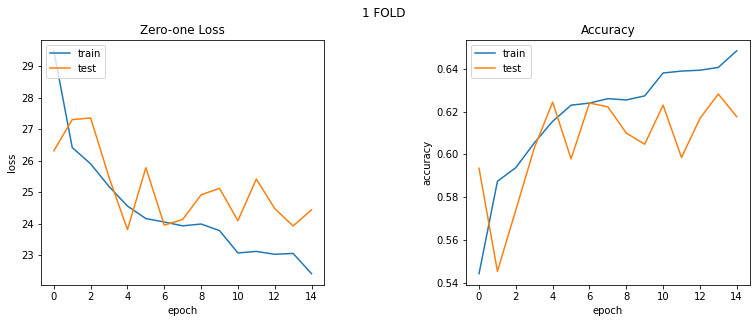

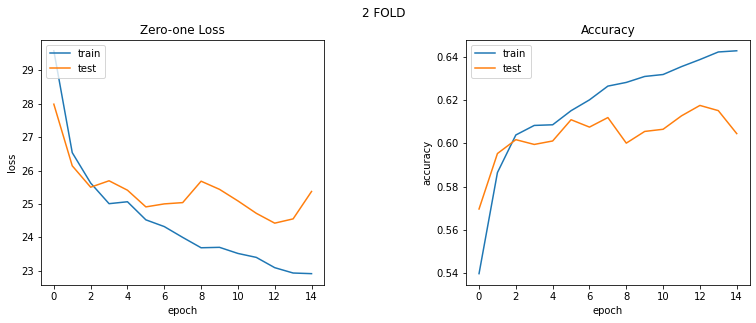

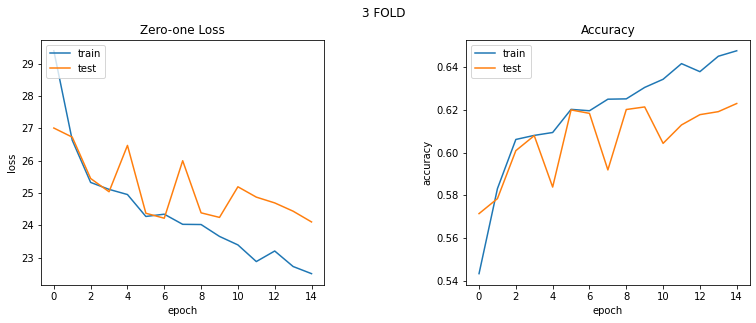

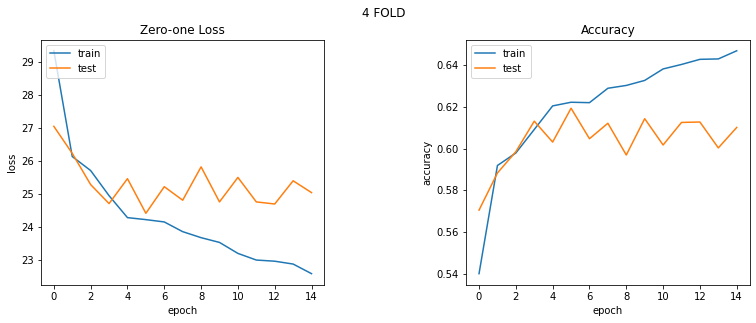

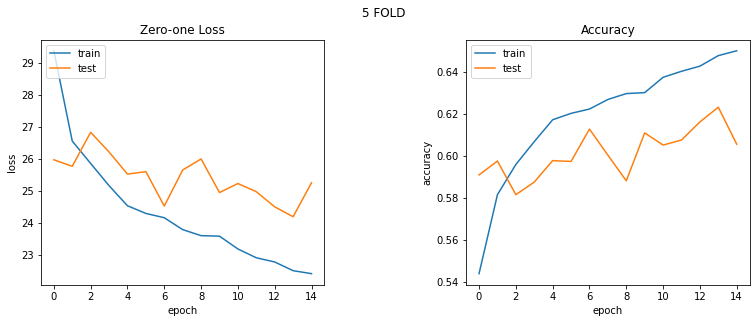

In [17]:
print("MLP Metrics - " + str(k) + "-fold cross validation estimate:")
print("0-1 LOSS : " + str(MLP_zeroOneLoss) + " (over batch size = " + str(batch_size) + ").")
print("BCE LOSS : " + str(MLP_binaryCrossEntropyLoss))
print("ACCURACY : " + str(MLP_accuracy))
print("-----------------------------------------------")
print("MLP - Train history:")
plot_train_history(MLP_history)

## Model 2: Convolutional Neural Network A - 3 Conv. layers, (16 32 64) output filters

In [13]:
CNN_A = tf.keras.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(100,100,1)),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),
    
    tf.keras.layers.Flatten(), 
    
    layers.Dense(512, activation='relu'),
    layers.Dense(2, activation='sigmoid')
], name = "CNN_A")
CNN_A.summary()

CNN_A.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[zero_one_loss, 'accuracy']
)

Model: "CNN_A"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       0     

### Run CNN_A

In [14]:
epochs = 15
batch_size = 64
k = 5
CNN_A_zeroOneLoss, CNN_A_binaryCrossEntropyLoss, CNN_A_accuracy, CNN_A_history = cross_validation(
    x, y, CNN_A, epochs, batch_size, k
)

Epoch 1/15
312/312 [==============================] - 13s 16ms/step - loss: 0.6104 - zero_one_loss: 22.2981 - accuracy: 0.6521 - val_loss: 0.5192 - val_zero_one_loss: 17.3333 - val_accuracy: 0.7298
Epoch 2/15
312/312 [==============================] - 3s 10ms/step - loss: 0.5039 - zero_one_loss: 15.7756 - accuracy: 0.7536 - val_loss: 0.4435 - val_zero_one_loss: 13.3205 - val_accuracy: 0.7923
Epoch 3/15
312/312 [==============================] - 3s 10ms/step - loss: 0.4334 - zero_one_loss: 12.9295 - accuracy: 0.7977 - val_loss: 0.4133 - val_zero_one_loss: 12.0897 - val_accuracy: 0.8106
Epoch 4/15
312/312 [==============================] - 3s 10ms/step - loss: 0.3858 - zero_one_loss: 11.2051 - accuracy: 0.8250 - val_loss: 0.4767 - val_zero_one_loss: 14.2308 - val_accuracy: 0.7771
Epoch 5/15
312/312 [==============================] - 3s 10ms/step - loss: 0.3445 - zero_one_loss: 9.7917 - accuracy: 0.8462 - val_loss: 0.3693 - val_zero_one_loss: 10.3462 - val_accuracy: 0.8386
Epoch 6/15
312/

Epoch 12/15
312/312 [==============================] - 3s 10ms/step - loss: 0.0763 - zero_one_loss: 1.7756 - accuracy: 0.9727 - val_loss: 0.5790 - val_zero_one_loss: 11.4615 - val_accuracy: 0.8214
Epoch 13/15
312/312 [==============================] - 3s 10ms/step - loss: 0.0493 - zero_one_loss: 1.0192 - accuracy: 0.9841 - val_loss: 0.6590 - val_zero_one_loss: 12.0128 - val_accuracy: 0.8126
Epoch 14/15
312/312 [==============================] - 3s 10ms/step - loss: 0.0319 - zero_one_loss: 0.6538 - accuracy: 0.9900 - val_loss: 0.7781 - val_zero_one_loss: 11.5897 - val_accuracy: 0.8186
Epoch 15/15
312/312 [==============================] - 3s 10ms/step - loss: 0.0213 - zero_one_loss: 0.3654 - accuracy: 0.9944 - val_loss: 0.8052 - val_zero_one_loss: 11.8590 - val_accuracy: 0.8136
156/156 - 0s - loss: 0.8052 - zero_one_loss: 5.9295 - accuracy: 0.8136 - 464ms/epoch - 3ms/step
Epoch 1/15
312/312 [==============================] - 3s 10ms/step - loss: 0.6115 - zero_one_loss: 21.7532 - accurac

### CNN_A Model Results

CNN_A Metrics - 5-fold cross validation estimate:
0-1 LOSS : 11.207692337036132 (over batch size = 64).
BCE LOSS : 0.7810935974121094
ACCURACY : 0.8246613502502441
-----------------------------------------------
CNN_A - Train history:


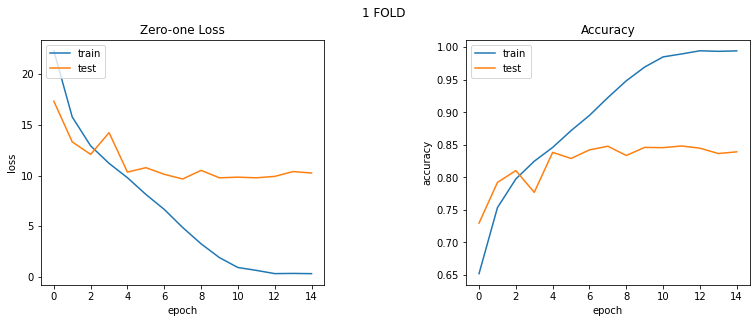

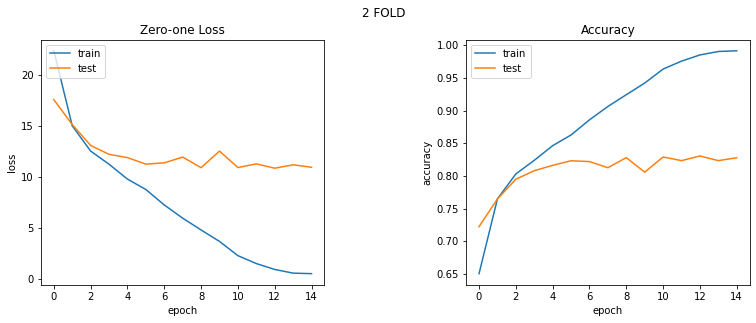

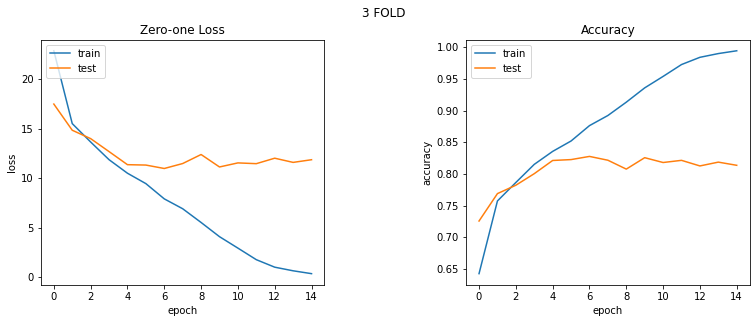

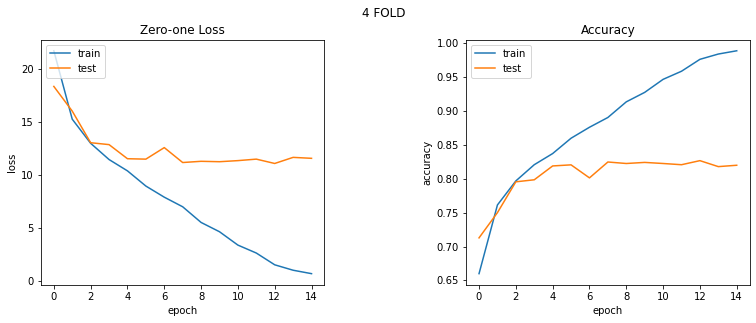

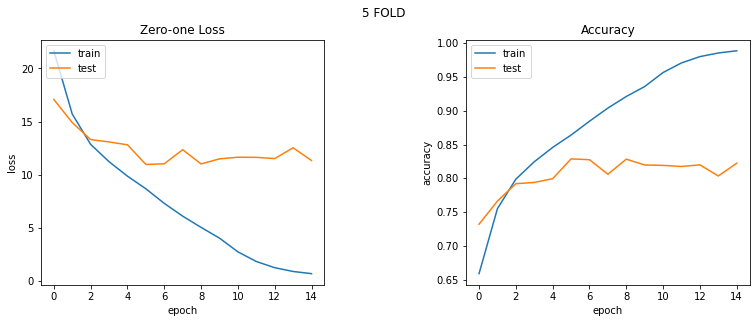

In [15]:
print("CNN_A Metrics - " + str(k) + "-fold cross validation estimate:")
print("0-1 LOSS : " + str(CNN_A_zeroOneLoss) + " (over batch size = " + str(batch_size) + ").")
print("BCE LOSS : " + str(CNN_A_binaryCrossEntropyLoss))
print("ACCURACY : " + str(CNN_A_accuracy))
print("-----------------------------------------------")
print("CNN_A - Train history:")
plot_train_history(CNN_A_history)

## Model 3: Convolutional Neural Network B - 4 Conv. layers, (32 64 128 128) output filters

In [13]:
CNN_B = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(100,100,1)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),
    
    tf.keras.layers.Flatten(), 
    
    layers.Dense(512, activation='relu'),
    layers.Dense(2, activation='sigmoid')
], name = "CNN_B")
CNN_B.summary()

CNN_B.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[zero_one_loss, 'accuracy']
)

Model: "CNN_B"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 128)      0     

### Run CNN_B

In [14]:
epochs = 15
batch_size = 64
k = 5
CNN_B_zeroOneLoss, CNN_B_binaryCrossEntropyLoss, CNN_B_accuracy, CNN_B_history = cross_validation(
    x, y, CNN_B, epochs, batch_size, k
)

Epoch 1/15
312/312 [==============================] - 18s 20ms/step - loss: 0.6701 - zero_one_loss: 26.9135 - accuracy: 0.5789 - val_loss: 0.5997 - val_zero_one_loss: 21.1154 - val_accuracy: 0.6689
Epoch 2/15
312/312 [==============================] - 5s 18ms/step - loss: 0.5467 - zero_one_loss: 17.8462 - accuracy: 0.7205 - val_loss: 0.5025 - val_zero_one_loss: 15.9872 - val_accuracy: 0.7503
Epoch 3/15
312/312 [==============================] - 5s 17ms/step - loss: 0.4644 - zero_one_loss: 14.0417 - accuracy: 0.7807 - val_loss: 0.4732 - val_zero_one_loss: 14.6154 - val_accuracy: 0.7725
Epoch 4/15
312/312 [==============================] - 5s 17ms/step - loss: 0.4102 - zero_one_loss: 12.0192 - accuracy: 0.8121 - val_loss: 0.3766 - val_zero_one_loss: 10.9872 - val_accuracy: 0.8280
Epoch 5/15
312/312 [==============================] - 5s 17ms/step - loss: 0.3465 - zero_one_loss: 9.7500 - accuracy: 0.8476 - val_loss: 0.3489 - val_zero_one_loss: 10.0385 - val_accuracy: 0.8447
Epoch 6/15
312/

Epoch 12/15
312/312 [==============================] - 5s 17ms/step - loss: 0.1713 - zero_one_loss: 4.4103 - accuracy: 0.9300 - val_loss: 0.3759 - val_zero_one_loss: 9.4872 - val_accuracy: 0.8525
Epoch 13/15
312/312 [==============================] - 5s 17ms/step - loss: 0.1404 - zero_one_loss: 3.5929 - accuracy: 0.9441 - val_loss: 0.3708 - val_zero_one_loss: 8.6923 - val_accuracy: 0.8633
Epoch 14/15
312/312 [==============================] - 5s 17ms/step - loss: 0.1142 - zero_one_loss: 2.8173 - accuracy: 0.9557 - val_loss: 0.3977 - val_zero_one_loss: 8.8846 - val_accuracy: 0.8615
Epoch 15/15
312/312 [==============================] - 5s 17ms/step - loss: 0.0845 - zero_one_loss: 2.0192 - accuracy: 0.9684 - val_loss: 0.4129 - val_zero_one_loss: 8.7692 - val_accuracy: 0.8627
156/156 - 1s - loss: 0.4129 - zero_one_loss: 4.3846 - accuracy: 0.8627 - 661ms/epoch - 4ms/step
Epoch 1/15
312/312 [==============================] - 5s 18ms/step - loss: 0.6796 - zero_one_loss: 28.2788 - accuracy: 0

### CNN_B Model Results

CNN_B Metrics - 5-fold cross validation estimate:
0-1 LOSS : 8.458974361419678 (over batch size = 64).
BCE LOSS : 0.46755859851837156
ACCURACY : 0.8678743243217468
-----------------------------------------------
CNN_B - Train history:


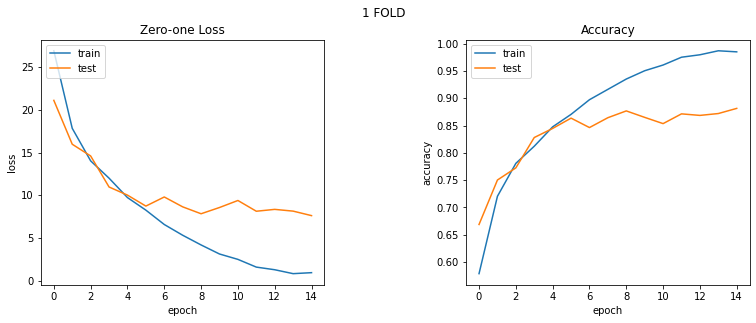

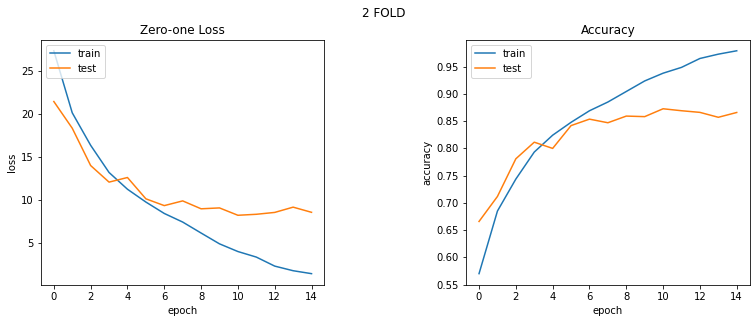

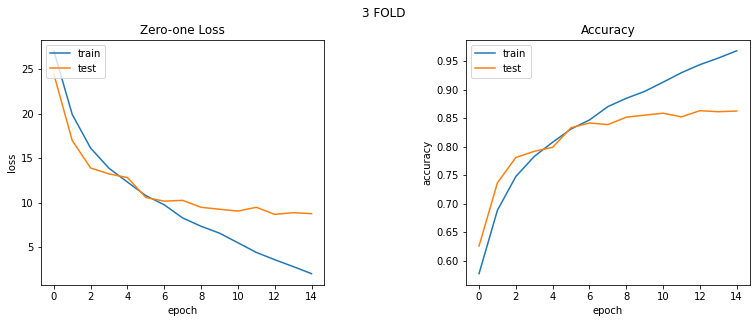

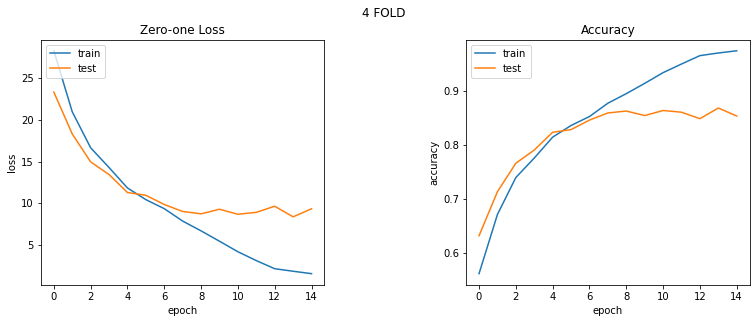

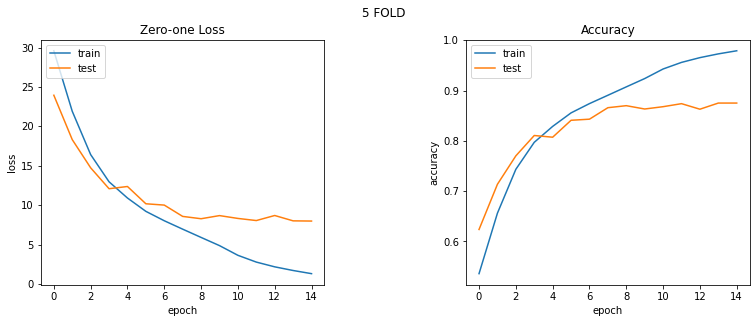

In [15]:
print("CNN_B Metrics - " + str(k) + "-fold cross validation estimate:")
print("0-1 LOSS : " + str(CNN_B_zeroOneLoss) + " (over batch size = " + str(batch_size) + ").")
print("BCE LOSS : " + str(CNN_B_binaryCrossEntropyLoss))
print("ACCURACY : " + str(CNN_B_accuracy))
print("-----------------------------------------------")
print("CNN_B - Train history:")
plot_train_history(CNN_B_history)

## Model 4: Convolutional Neural Network + Dropout (over Dense Layer only)

In [13]:
CNN_d_dense = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(100,100,1)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),
    
    tf.keras.layers.Flatten(),
    
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    
    layers.Dense(2, activation='sigmoid')
], name = "CNN_d_dense")
CNN_d_dense.summary()

CNN_d_dense.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[zero_one_loss, 'accuracy']
)

Model: "CNN_d_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 128)      

## Run CNN_Dropout_DenseLayer

In [14]:
epochs = 15
batch_size = 64
k = 5
CNN_d_dense_zeroOneLoss, CNN_d_dense_binaryCrossEntropyLoss, CNN_d_dense_accuracy, CNN_d_dense_history = cross_validation(
    x, y, CNN_d_dense, epochs, batch_size, k
)

Epoch 1/15
312/312 [==============================] - 9s 17ms/step - loss: 0.6451 - zero_one_loss: 24.9263 - accuracy: 0.6095 - val_loss: 0.6021 - val_zero_one_loss: 21.1154 - val_accuracy: 0.6727
Epoch 2/15
312/312 [==============================] - 5s 16ms/step - loss: 0.5261 - zero_one_loss: 16.9455 - accuracy: 0.7348 - val_loss: 0.4537 - val_zero_one_loss: 13.6026 - val_accuracy: 0.7877
Epoch 3/15
312/312 [==============================] - 5s 16ms/step - loss: 0.4447 - zero_one_loss: 13.1731 - accuracy: 0.7937 - val_loss: 0.3960 - val_zero_one_loss: 11.4103 - val_accuracy: 0.8214
Epoch 4/15
312/312 [==============================] - 5s 16ms/step - loss: 0.3798 - zero_one_loss: 10.8718 - accuracy: 0.8303 - val_loss: 0.3497 - val_zero_one_loss: 9.9231 - val_accuracy: 0.8447
Epoch 5/15
312/312 [==============================] - 5s 16ms/step - loss: 0.3231 - zero_one_loss: 9.0000 - accuracy: 0.8589 - val_loss: 0.2865 - val_zero_one_loss: 8.3205 - val_accuracy: 0.8703
Epoch 6/15
312/312

Epoch 12/15
312/312 [==============================] - 5s 16ms/step - loss: 0.1786 - zero_one_loss: 4.7532 - accuracy: 0.9255 - val_loss: 0.2710 - val_zero_one_loss: 7.5641 - val_accuracy: 0.8817
Epoch 13/15
312/312 [==============================] - 5s 16ms/step - loss: 0.1631 - zero_one_loss: 4.3494 - accuracy: 0.9321 - val_loss: 0.2699 - val_zero_one_loss: 7.0000 - val_accuracy: 0.8898
Epoch 14/15
312/312 [==============================] - 5s 16ms/step - loss: 0.1491 - zero_one_loss: 3.9583 - accuracy: 0.9373 - val_loss: 0.2542 - val_zero_one_loss: 6.6410 - val_accuracy: 0.8964
Epoch 15/15
312/312 [==============================] - 5s 16ms/step - loss: 0.1241 - zero_one_loss: 3.0994 - accuracy: 0.9510 - val_loss: 0.2616 - val_zero_one_loss: 6.7051 - val_accuracy: 0.8948
156/156 - 1s - loss: 0.2616 - zero_one_loss: 3.3526 - accuracy: 0.8948 - 649ms/epoch - 4ms/step
Epoch 1/15
312/312 [==============================] - 5s 17ms/step - loss: 0.6579 - zero_one_loss: 26.0897 - accuracy: 0

### CNN_Dropout_Dense Model Results

CNN_droput_dense Metrics - 5-fold cross validation estimate:
0-1 LOSS : 6.57179479598999 (over batch size = 64).
BCE LOSS : 0.2822296440601349
ACCURACY : 0.8973781704902649
-----------------------------------------------
CNN_dropout_dense - Train history:


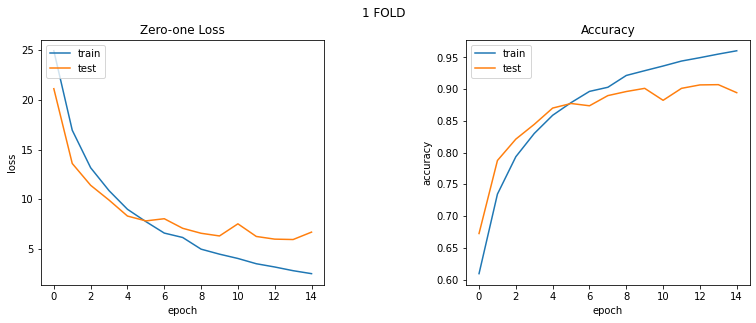

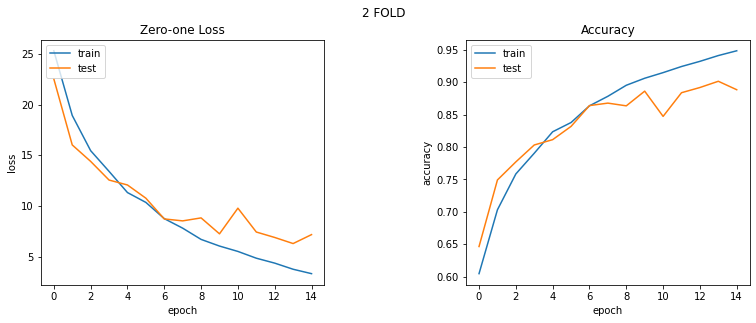

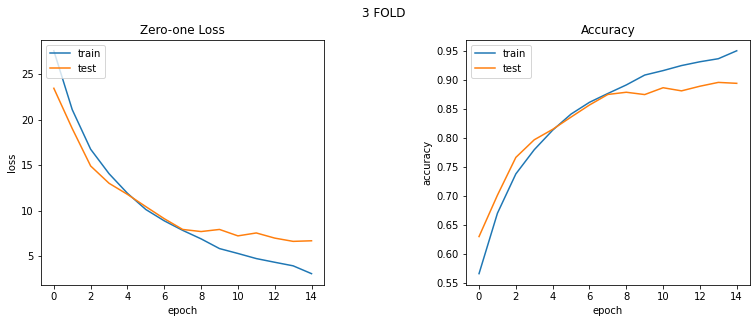

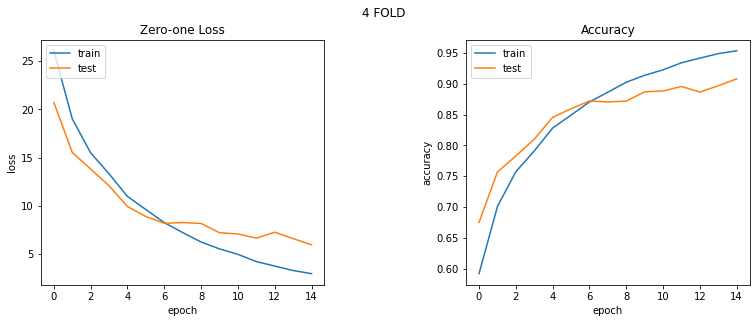

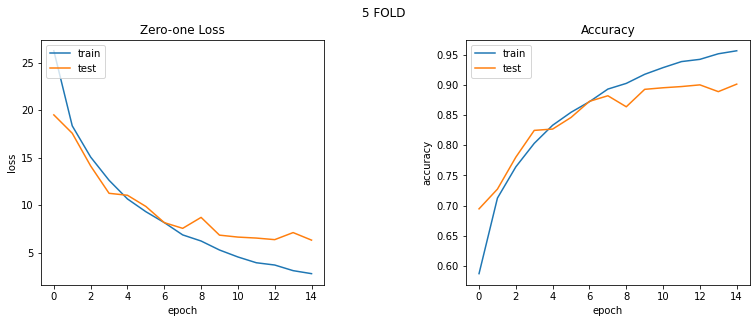

In [15]:
print("CNN_dropout_dense Metrics - " + str(k) + "-fold cross validation estimate:")
print("0-1 LOSS : " + str(CNN_d_dense_zeroOneLoss) + " (over batch size = " + str(batch_size) + ").")
print("BCE LOSS : " + str(CNN_d_dense_binaryCrossEntropyLoss))
print("ACCURACY : " + str(CNN_d_dense_accuracy))
print("-----------------------------------------------")
print("CNN_dropout_dense - Train history:")
plot_train_history(CNN_d_dense_history)

## Model 5: Convolutional Neural Network + Dropout (over Conv2D)

In [13]:
CNN_d = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(100,100,1)),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    
    layers.Dense(512, activation='relu'),
    layers.Dense(2, activation='sigmoid')
], name = "CNN_d")
CNN_d.summary()

CNN_d.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[zero_one_loss, 'accuracy']
)

Model: "CNN_d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 50, 50, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 25, 25, 64)        0     

## Run CNN_Dropout

In [14]:
epochs = 15
batch_size = 64
k = 5
CNN_d_zeroOneLoss, CNN_d_binaryCrossEntropyLoss, CNN_d_accuracy, CNN_d_history = cross_validation(
    x, y, CNN_d, epochs, batch_size, k
)

Epoch 1/15
312/312 [==============================] - 11s 19ms/step - loss: 0.6490 - zero_one_loss: 24.9199 - accuracy: 0.6065 - val_loss: 0.5790 - val_zero_one_loss: 19.5513 - val_accuracy: 0.6967
Epoch 2/15
312/312 [==============================] - 5s 17ms/step - loss: 0.5238 - zero_one_loss: 16.6378 - accuracy: 0.7401 - val_loss: 0.4567 - val_zero_one_loss: 14.0128 - val_accuracy: 0.7803
Epoch 3/15
312/312 [==============================] - 5s 18ms/step - loss: 0.4448 - zero_one_loss: 13.4071 - accuracy: 0.7908 - val_loss: 0.4237 - val_zero_one_loss: 12.6795 - val_accuracy: 0.8020
Epoch 4/15
312/312 [==============================] - 5s 18ms/step - loss: 0.3904 - zero_one_loss: 11.2949 - accuracy: 0.8234 - val_loss: 0.4459 - val_zero_one_loss: 13.2436 - val_accuracy: 0.7927
Epoch 5/15
312/312 [==============================] - 5s 17ms/step - loss: 0.3495 - zero_one_loss: 9.8846 - accuracy: 0.8456 - val_loss: 0.3553 - val_zero_one_loss: 10.6667 - val_accuracy: 0.8322
Epoch 6/15
312/

Epoch 12/15
312/312 [==============================] - 6s 18ms/step - loss: 0.2818 - zero_one_loss: 7.9135 - accuracy: 0.8764 - val_loss: 0.3115 - val_zero_one_loss: 8.5641 - val_accuracy: 0.8655
Epoch 13/15
312/312 [==============================] - 6s 18ms/step - loss: 0.2597 - zero_one_loss: 7.0321 - accuracy: 0.8905 - val_loss: 0.3436 - val_zero_one_loss: 9.8077 - val_accuracy: 0.8463
Epoch 14/15
312/312 [==============================] - 5s 18ms/step - loss: 0.2335 - zero_one_loss: 6.1987 - accuracy: 0.9030 - val_loss: 0.2853 - val_zero_one_loss: 7.5641 - val_accuracy: 0.8809
Epoch 15/15
312/312 [==============================] - 6s 18ms/step - loss: 0.2175 - zero_one_loss: 5.7628 - accuracy: 0.9099 - val_loss: 0.2612 - val_zero_one_loss: 7.0897 - val_accuracy: 0.8884
156/156 - 1s - loss: 0.2612 - zero_one_loss: 3.5449 - accuracy: 0.8884 - 622ms/epoch - 4ms/step
Epoch 1/15
312/312 [==============================] - 6s 18ms/step - loss: 0.6932 - zero_one_loss: 29.9487 - accuracy: 0

### CNN_Dropout Model Results

CNN_droput Metrics - 5-fold cross validation estimate:
0-1 LOSS : 6.989743614196778 (over batch size = 64).
BCE LOSS : 0.2681012094020844
ACCURACY : 0.8904432535171509
-----------------------------------------------
CNN_dropout - Train history:


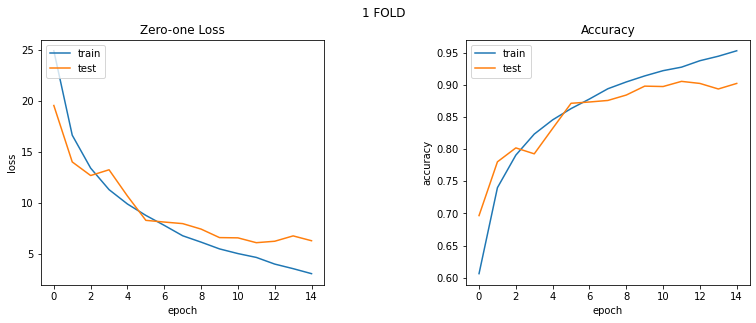

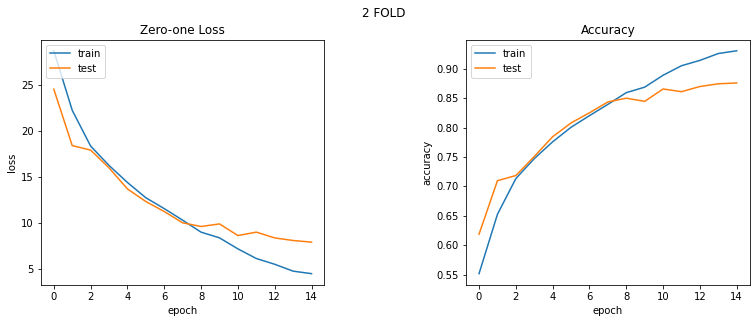

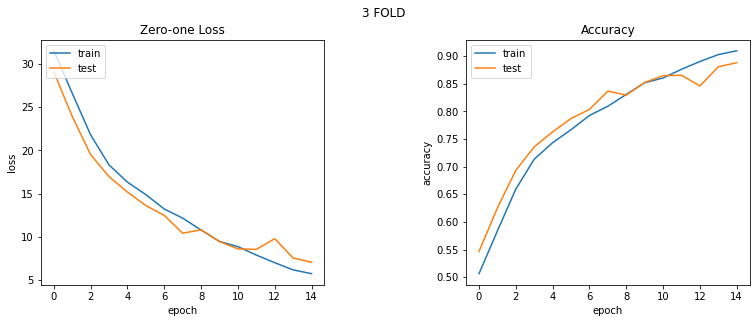

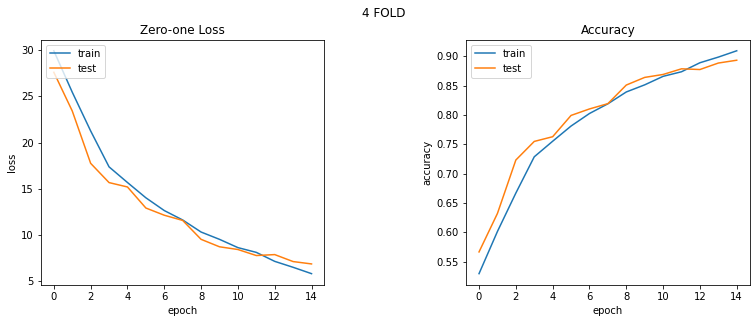

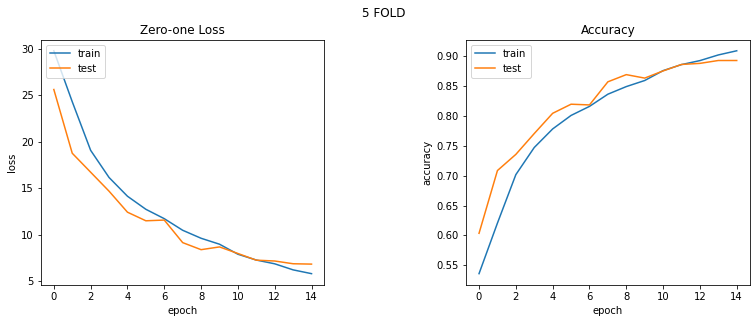

In [15]:
print("CNN_dropout Metrics - " + str(k) + "-fold cross validation estimate:")
print("0-1 LOSS : " + str(CNN_d_zeroOneLoss) + " (over batch size = " + str(batch_size) + ").")
print("BCE LOSS : " + str(CNN_d_binaryCrossEntropyLoss))
print("ACCURACY : " + str(CNN_d_accuracy))
print("-----------------------------------------------")
print("CNN_dropout - Train history:")
plot_train_history(CNN_d_history)

## Predicting using a model

#### Function: K-fold Cross Validation to pick the best trained model

    Parameters
    ------------------------
    x, y: np.array
    Inputs and labels.
    
    model: keras.engine.sequential.Sequential
    The model to evaluate.
    
    epochs: int
    The number of times the learning algorithm works through the dataset.
    
    batch_size: int
    The number of samples to work through before updating the model.
    
    k: int
    The number of folds.
        
    Returns
    ------------------------ 
    best_accuracy: int
    The accuracy of the best trained model found over the k folds.
    
    Run the Cross validation algorithm and saves the weights of the model with the best accuracy of the k trained for               deployment.

In [14]:
def cross_validation_pick_best(x, y, model, epochs, batch_size, k):
    x, y = shuffle(x, y)
    
    ## Create folds
    foldSize = int(len(x)/k)
    x_folds = []
    y_folds = []
    foldStartIndex = 0
    foldEndIndex = foldSize
    
    for i in range(k):
        # Last fold may be a little bit bigger for the approximation of the foldSize
        if (i == k-1):
            x_folds.append(x[foldStartIndex:])
            y_folds.append(y[foldStartIndex:])
            break

        x_folds.append(x[foldStartIndex:foldEndIndex])
        y_folds.append(y[foldStartIndex:foldEndIndex])
        foldStartIndex += foldSize
        foldEndIndex += foldSize

    ## Train and evaluate model over the folds
    # Save untrained weights
    model.save_weights('startingModel.h5')
    best_accuracy = 0
    
    for i in range(k):
        x_train_list = ((x_folds[:i] + x_folds[i+1:]))
        y_train_list = ((y_folds[:i] + y_folds[i+1:]))
        x_test = ((x_folds[i]))
        y_test = ((y_folds[i]))
        
        # Unpack train folds list
        x_train = []
        x_train = list(itertools.chain(*x_train_list))

        y_train = []
        y_train = list(itertools.chain(*y_train_list))
        
        # Reset model weights
        model.load_weights('startingModel.h5')
        
        fold_train_history = train_model(model, epochs, batch_size, np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test))
        
        test_BCE_loss, test_zero_one_loss, test_accuracy = model.evaluate(np.array(x_test), np.array(y_test), verbose=2)
        
        # Save the best trained model
        if (test_accuracy > best_accuracy):
            model.save_weights('bestModel.h5')
            best_accuracy = test_accuracy

    return best_accuracy

## Run the model

In [15]:
model = CNN_d_dense
epochs = 15
batch_size = 64
k = 5
best_accuracy = cross_validation_pick_best(
    x, y, model, epochs, batch_size, k
)

Epoch 1/15
312/312 [==============================] - 9s 18ms/step - loss: 0.6803 - zero_one_loss: 28.4936 - accuracy: 0.5555 - val_loss: 0.6459 - val_zero_one_loss: 23.3974 - val_accuracy: 0.6336
Epoch 2/15
312/312 [==============================] - 5s 16ms/step - loss: 0.6124 - zero_one_loss: 21.5417 - accuracy: 0.6625 - val_loss: 0.5422 - val_zero_one_loss: 16.9231 - val_accuracy: 0.7366
Epoch 3/15
312/312 [==============================] - 5s 17ms/step - loss: 0.5171 - zero_one_loss: 16.2596 - accuracy: 0.7461 - val_loss: 0.4206 - val_zero_one_loss: 12.2821 - val_accuracy: 0.8080
Epoch 4/15
312/312 [==============================] - 5s 16ms/step - loss: 0.4333 - zero_one_loss: 12.9103 - accuracy: 0.7989 - val_loss: 0.3645 - val_zero_one_loss: 9.9615 - val_accuracy: 0.8429
Epoch 5/15
312/312 [==============================] - 5s 16ms/step - loss: 0.3798 - zero_one_loss: 11.1314 - accuracy: 0.8256 - val_loss: 0.3777 - val_zero_one_loss: 11.1154 - val_accuracy: 0.8264
Epoch 6/15
312/3

Epoch 12/15
312/312 [==============================] - 5s 16ms/step - loss: 0.2178 - zero_one_loss: 5.9006 - accuracy: 0.9081 - val_loss: 0.2776 - val_zero_one_loss: 7.3846 - val_accuracy: 0.8843
Epoch 13/15
312/312 [==============================] - 5s 16ms/step - loss: 0.2002 - zero_one_loss: 5.2628 - accuracy: 0.9178 - val_loss: 0.2758 - val_zero_one_loss: 7.4744 - val_accuracy: 0.8833
Epoch 14/15
312/312 [==============================] - 5s 16ms/step - loss: 0.1715 - zero_one_loss: 4.5609 - accuracy: 0.9290 - val_loss: 0.2713 - val_zero_one_loss: 7.2564 - val_accuracy: 0.8861
Epoch 15/15
312/312 [==============================] - 5s 16ms/step - loss: 0.1620 - zero_one_loss: 4.2981 - accuracy: 0.9331 - val_loss: 0.2967 - val_zero_one_loss: 7.5128 - val_accuracy: 0.8823
156/156 - 1s - loss: 0.2967 - zero_one_loss: 3.7564 - accuracy: 0.8823 - 629ms/epoch - 4ms/step
Epoch 1/15
312/312 [==============================] - 5s 17ms/step - loss: 0.6740 - zero_one_loss: 27.6955 - accuracy: 0

## Model results

In [16]:
print("Best trained model found during cross validation has accuracy: " + str(best_accuracy))

# Loading weights of the best trained model found during k-fold cross validation
model.load_weights('bestModel.h5')

Best trained model found during cross validation has accuracy: 0.9019843935966492


#### Function: Predict

    Parameters
    ------------------------
    folder: str
    The name of the folder from which import images.

    model: keras.engine.sequential.Sequential
    The model to use for classification.
    
    Returns
    ------------------------
    imgs: np.array
    The images classified.
    
    predictions: list
    The predicted labels for each image.

In [17]:
def predict(folder, model):
    imgs = loadArrangeImages(folder),
    output = model.predict(imgs[0]/255)
    predictions = []
    for i in range(len(output)):
        if output[i][0] > 0.5:
            predictions.append("cat")
        else: predictions.append("dog")
    return np.array(imgs), predictions

### Classify some new images

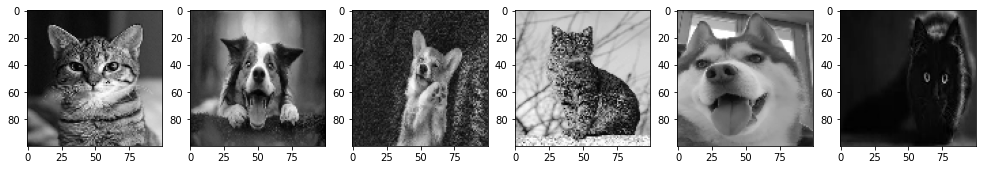

Predictions: ['cat', 'dog', 'dog', 'cat', 'dog', 'cat']


In [18]:
folder = 'D:\CatDog_Dataset\CatsDogs\Images'
images, predictions = predict(folder, model)

fig = plt.figure(figsize=(17, 17))
for i in range(len(images[0])):
    plt.subplot(1,len(images[0]),i+1).imshow(images[0][i], cmap='gray', vmin=0, vmax=255)
plt.show()
print("Predictions: " + str(predictions))